<a href="https://colab.research.google.com/github/parmarsuraj99/numerai-guides/blob/master/EraTransformer/NumeraiTransformerEra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An attempt to feed entire era as sequence to a Transformer with some tricks around memory efficiency on limited GPU compute of Colab.

I tried playing around with the models, not sure if this is an acceptable implementation of Transformers but seem to be working.

Twitter: [@parmarsuraj99](https://twitter.com/parmarsuraj99), RC: surajp

In [ ]:
!nvidia-smi

Mon Mar 27 01:01:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install numerapi

In [ ]:
from numerapi import NumerAPI
napi = NumerAPI()

napi.download_dataset("v4.1/train_int8.parquet", "../data/train.parquet")
napi.download_dataset("v4.1/validation_int8.parquet", "../data/validation.parquet")
napi.download_dataset("v4.1/live_int8.parquet", "../data/live.parquet")
napi.download_dataset("v4.1/live_example_preds.parquet", "../data/live_example_preds.parquet")
napi.download_dataset("v4.1/validation_example_preds.parquet", "../data/validation_example_preds.parquet")
napi.download_dataset("v4.1/features.json", "../data/features.json")
napi.download_dataset("v4.1/meta_model.parquet", "../data/meta_model.parquet")

Run all

In [ ]:
import gc, os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import json

import joblib
from joblib import Parallel, delayed

from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, normalize

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import math

from numerapi import NumerAPI

tqdm.pandas()

In [ ]:
# read data from parquet files
# to reduce the memory usage on low memory Colab instance, read live data for col info

with open("../data/features.json") as f:
    features_meta = json.load(f)

features_to_load = features_meta["feature_sets"]["small"] # medium or all features

live = pd.read_parquet("../data/live.parquet")

cols_to_ignore = [
    c for c in live.columns if (c not in features_to_load and "feature_" in c)
]
cols_to_load = [c for c in live.columns if c not in cols_to_ignore]

train = pd.read_parquet("../data/train.parquet", columns=cols_to_load)
validation = pd.read_parquet("../data/validation.parquet", columns=cols_to_load)
live = pd.read_parquet("../data/live.parquet", columns=cols_to_load)

live_example_preds = pd.read_parquet("../data/live_example_preds.parquet")
validation_example_preds = pd.read_parquet("../data/validation_example_preds.parquet")
meta_model = pd.read_parquet("../data/meta_model.parquet")

feature_names = [f for f in train.columns if "feature_" in f]
feature_names = [f for f in feature_names if f in features_to_load]
target_names = [t for t in train.columns if "target_" in t]#[:5]

TARGET_NAME = target_names[0]
PREDICTION_NAME = "prediction"

# all eras of TARGET_NAME must be present in diagnostics
validation = validation.dropna(subset=[TARGET_NAME], axis=0).copy()
gc.collect()

train["era_int"] = train["era"].astype(int)
validation["era_int"] = validation["era"].astype(int)
gc.collect()

train[feature_names] = train[feature_names].fillna(-2)
validation[feature_names] = validation[feature_names].fillna(-2)
gc.collect()

# use a better method to handle NaN in targets
train[target_names] = train[target_names].fillna(0.5)
validation[target_names] = validation[target_names].fillna(0.5)
gc.collect()

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"


In [ ]:
PADDING_VALUE = -1 
MAX_LEN = 6000
FEATUER_DIM = len(feature_names)
HIDDEN_DIM = 128
OUTPUT_DIM = len(target_names)
NUM_HEADS = 2
NUM_LAYERS = 2

In [ ]:
# caching

def pad_sequence(inputs, padding_value=-1, max_len=None):
    if max_len is None:
        max_len = max([input.shape[0] for input in inputs])
    padded_inputs = []
    masks = []
    for input in inputs:
        pad_len = max_len - input.shape[0]
        padded_input = F.pad(input, (0, 0, 0, pad_len), value=padding_value)
        mask = torch.ones((input.shape[0], 1), dtype=torch.float)
        masks.append(
            torch.cat((mask, torch.zeros((pad_len, 1), dtype=torch.float)), dim=0)
        )
        padded_inputs.append(padded_input)
    return torch.stack(padded_inputs), torch.stack(masks)

def convert_to_torch(era, data):

    inputs = torch.from_numpy(
                data[feature_names].values.astype(np.int8))
    labels = torch.from_numpy(
                data[target_names].values.astype(np.float32))
    
    padded_inputs, masks_inputs = pad_sequence(
            [inputs], padding_value=PADDING_VALUE, max_len=MAX_LEN)
    padded_labels, masks_labels = pad_sequence(
            [labels], padding_value=PADDING_VALUE, max_len=MAX_LEN)

    return {
        era: (
            padded_inputs,
            padded_labels,
            masks_inputs
        )
    }

def get_era2data(df):
    res = Parallel(n_jobs=-1, prefer="threads")(
        delayed(convert_to_torch)(era, data)
        for era, data in tqdm(df.groupby("era_int")))
    era2data = {}
    for r in tqdm(res):
        era2data.update(r)
    return era2data

era2data_train = get_era2data(train)
era2data_validation = get_era2data(validation)

100%|██████████| 477/477 [00:00<00:00, 835707.19it/s]


Use better attention mechanism that doesn't give OOM


THis might help
- https://github.com/lucidrains/linear-attention-transformer

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Didn't have much difference
    """

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-torch.log(torch.tensor(10000.0)) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

class LinearAttentionWithKQV(nn.Module):
    """
    Light on compute. MAX_LEN x D_MODEL; 
    use this if OOM
    """

    def __init__(self, d_model, dropout=0.1):
        super(LinearAttentionWithKQV, self).__init__()
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.dim = d_model
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs, mask=None):
        k = self.linear_k(inputs)
        q = self.linear_q(inputs)
        v = self.linear_v(inputs)
        n = torch.sqrt(torch.tensor(self.dim, dtype=torch.float32))

        scores = torch.bmm(k.transpose(1, 2), v) / n
        scores = self.dropout(scores)

        # print(scores.shape, mask.shape)
        if mask is not None:
            q = q.masked_fill(mask == 0, float("-inf"))
        
        q = torch.softmax(q, dim=1)

        attention_weights = torch.bmm(q, scores) / n

        return attention_weights


class FeedForwardLayer(nn.Module):
    def __init__(self, d_model, d_ff=128, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

class SelfAttention(nn.Module):
    """
    Heavy on compute. Vanilla attention MAXLEN x MAXLEN
    """

    def __init__(self, d_model, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.dim = d_model
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs, mask=None):
        k = self.linear_k(inputs)
        q = self.linear_q(inputs)
        v = self.linear_v(inputs)
        n = torch.sqrt(torch.tensor(self.dim, dtype=torch.float32))

        scores = torch.bmm(q, k.transpose(1, 2)) / n
        # print(scores.shape)
        if mask is not None:
            scores = scores .masked_fill(mask == 0, float("-inf"))

        attention_weights = torch.softmax(scores, dim=1)
        attention_weights = self.dropout(attention_weights)

        attention_weights = torch.bmm(attention_weights, v) / n
        
        return attention_weights

class MultiHeadLinearAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadLinearAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        #self.attention = LinearAttentionWithKQV(d_model, dropout=0.1)  # drop-in attention
        self.attention = SelfAttention(d_model, dropout=0.15)
        self.layers = nn.ModuleList(
            [nn.Linear(d_model, d_model) for _ in range(num_heads)]
        )
        self.fc = nn.Linear(num_heads * d_model, d_model)

    def forward(self, inputs, mask=None):
        x = inputs
        head_outputs = []
        for layer in range(self.num_heads):
            attention_weights = self.attention(x, mask)
            head_output = x * attention_weights
            head_output = self.layers[layer](head_output)
            head_output = F.relu(head_output)
            head_outputs.append(head_output)

        concatenated = torch.cat(head_outputs, dim=-1)
        output = self.fc(concatenated)

        return output


class TransformerEncoder(nn.Module):
    def __init__(
        self,
        input_dim,
        d_model,
        output_dim,
        num_heads,
        num_layers,
        dropout_prob=0.15,
        max_len=5000,
    ):
        super(TransformerEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob
        self.d_model = d_model

        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.attention = MultiHeadLinearAttention(d_model, num_heads)
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model),
        )
        self.layers = nn.ModuleList(
            [
                nn.Sequential(FeedForwardLayer(d_model=d_model))
                for _ in range(num_layers)
            ]
        )
        self.mapper = nn.Sequential(
            nn.Linear(input_dim, d_model), nn.Linear(d_model, d_model)
        )

    def forward(self, inputs, mask=None):
        x = self.mapper(inputs)
        pe = self.positional_encoding(x)
        x = x + pe # works without PE as well
        for layer in range(self.num_layers):
            attention_weights = self.attention(x, mask)
            x = x + attention_weights
            x = F.layer_norm(x, x.shape[1:])
            x = F.dropout(x, p=self.dropout_prob)

            op = self.layers[layer](x)
            x = x + op
            x = F.layer_norm(x, x.shape[1:])
            x = F.dropout(x, p=self.dropout_prob)

        outputs = self.fc(x)
        return outputs


class Transformer(nn.Module):
    def __init__(
        self,
        input_dim,
        d_model,
        output_dim,
        num_heads,
        num_layers,
        dropout_prob=0.15,
        max_len=5000,
    ):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob
        self.d_model = d_model

        self.encoder = TransformerEncoder(
            input_dim=input_dim,
            d_model=d_model,
            output_dim=output_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            max_len=max_len,
        )
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.SELU(),
            nn.Linear(d_model // 2, self.output_dim),
            nn.Sigmoid(),
        )

    def forward(self, inputs, mask=None):
        emb = self.encoder(inputs, mask)
        outputs = self.fc(emb)
        return outputs


def test_model():

    inputs = [
        torch.randint(0, 4, (5, FEATUER_DIM)).float(),
        torch.randint(0, 4, (3, FEATUER_DIM)).float(),
    ]
    labels = [
        torch.randint(0, 2, (5, OUTPUT_DIM)).float(),
        torch.randint(0, 2, (3, OUTPUT_DIM)).float(),
    ]

    padded_inputs, masks_inputs = pad_sequence(inputs, padding_value=0, max_len=MAX_LEN)
    padded_labels, masks_labels = pad_sequence(labels, padding_value=0, max_len=MAX_LEN)

    transformer = Transformer(
        input_dim=FEATUER_DIM,
        d_model=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        max_len=MAX_LEN,
    )

    with torch.no_grad():
        outputs = transformer(padded_inputs, masks_inputs)

    assert torch.isnan(outputs).sum() == 0
    assert outputs.shape[:2] == padded_inputs.shape[:2]
    assert outputs.shape[-1] == len(target_names)

    print("Input Shape:", padded_inputs.shape)
    print("Output Shape:", outputs.shape)

    del transformer
    del inputs, labels
    del padded_inputs, masks_inputs, padded_labels, masks_labels
    del outputs

    gc.collect()

test_model()

Input Shape: torch.Size([2, 6000, 32])
Output Shape: torch.Size([2, 6000, 28])


In [ ]:
# pearsonr in torch differentiable
def pearsonr(x, y):
    mx = x.mean()
    my = y.mean()
    xm, ym = x - mx, y - my
    r_num = torch.sum(xm * ym)
    r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2))
    r = r_num / r_den
    return r

In [ ]:
def calculate_loss(outputs, padded_labels, masks_inputs, padded_inputs=None):

    # MSE on all targets; additionally, on primary target
    _mse = criterion(outputs * masks_inputs, padded_labels * masks_inputs) * 0.1
    _mse += criterion(outputs[:, 0] * masks_inputs, padded_labels[:, 0] * masks_inputs)

    # Corr with only primary target; adjust as needed
    corr = pearsonr(
        outputs[0][:, 0][masks_inputs.view(-1).nonzero()].view(-1, 1),
        padded_labels[0][:, 0][masks_inputs.view(-1).nonzero()].view(-1, 1),
    )

    loss = _mse - corr
    return loss, _mse, corr


# Training loop
def train_on_batch(transformer, optimizer, batch):

    padded_inputs = batch[0].to(device=device)
    padded_labels = batch[1].to(device=device)
    masks_inputs = batch[2].to(device=device)

    optimizer.zero_grad()

    outputs = transformer(padded_inputs / 4.0, masks_inputs)
    loss, _mse, _corr = calculate_loss(outputs, padded_labels, masks_inputs)
    loss.backward()
    optimizer.step()
    return loss.item(), _mse.item(), _corr.item()


def evaluate_on_batch(transformer, batch):

    padded_inputs = batch[0].to(device=device)
    padded_labels = batch[1].to(device=device)
    masks_inputs = batch[2].to(device=device)

    outputs = transformer(padded_inputs / 4.0, masks_inputs)
    loss, _mse, _corr = calculate_loss(outputs, padded_labels, masks_inputs)
    return loss.item(), _mse.item(), _corr.item()


def train_model(transformer, optimizer, num_epochs, train_loader, val_loader):
    for epoch in range(num_epochs):
        total_loss = []
        total_corr = []
        print(f"\nEPOCH: {epoch+1}/{num_epochs}")
        for era_num in tqdm(train_loader):
            batch = train_loader[era_num]
            loss, _mse, _corr = train_on_batch(transformer, optimizer, batch)
            total_loss.append(loss)
            total_corr.append(_corr)
        print(
            f"Train Loss: {np.mean(total_loss):.4f} | Train Corr: {np.mean(total_corr):.4f}"
        )

        transformer.eval()
        with torch.no_grad():
            
            total_loss = []
            total_corr = []
            for era_num in tqdm(val_loader):
                batch = val_loader[era_num]
                loss, _mse, _corr = evaluate_on_batch(transformer, batch)
                total_loss.append(loss)
                total_corr.append(_corr)
            print(
                f"Val Loss: {np.mean(total_loss):.4f} | Val Corr: {np.mean(total_corr):.4f}"
            )

        torch.cuda.empty_cache()
        _ = gc.collect()
    
    torch.save(transformer.state_dict(), f"transformer.pth")

    return transformer

# Define the model, loss function, and optimizer

gc.collect()
transformer = Transformer(
    input_dim=FEATUER_DIM,
    d_model=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
)

# load model from checkpoint
if "transformer.pth" in os.listdir():
    transformer.load_state_dict(torch.load("transformer.pth"))

transformer.to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer.parameters(), lr=1e-4)

# Number of training iterations
# Train for longer with low LR

num_epochs = 10

transformer = train_model(transformer, optimizer, num_epochs, era2data_train, era2data_validation)


EPOCH: 1/10


100%|██████████| 574/574 [01:44<00:00,  5.50it/s]


Train Loss: 0.0076 | Train Corr: 0.0306


100%|██████████| 477/477 [00:36<00:00, 13.05it/s]


Val Loss: 0.0263 | Val Corr: 0.0168

EPOCH: 2/10


100%|██████████| 574/574 [01:36<00:00,  5.92it/s]


Train Loss: -0.0014 | Train Corr: 0.0385


100%|██████████| 477/477 [00:36<00:00, 13.02it/s]


Val Loss: 0.0252 | Val Corr: 0.0180

EPOCH: 3/10


100%|██████████| 574/574 [01:37<00:00,  5.91it/s]


Train Loss: -0.0038 | Train Corr: 0.0406


100%|██████████| 477/477 [00:37<00:00, 12.87it/s]


Val Loss: 0.0228 | Val Corr: 0.0200

EPOCH: 4/10


100%|██████████| 574/574 [01:37<00:00,  5.89it/s]


Train Loss: -0.0055 | Train Corr: 0.0422


100%|██████████| 477/477 [00:37<00:00, 12.86it/s]


Val Loss: 0.0223 | Val Corr: 0.0207

EPOCH: 5/10


100%|██████████| 574/574 [01:37<00:00,  5.90it/s]


Train Loss: -0.0062 | Train Corr: 0.0428


100%|██████████| 477/477 [00:37<00:00, 12.78it/s]


Val Loss: 0.0218 | Val Corr: 0.0211

EPOCH: 6/10


100%|██████████| 574/574 [01:37<00:00,  5.89it/s]


Train Loss: -0.0066 | Train Corr: 0.0431


100%|██████████| 477/477 [00:37<00:00, 12.65it/s]


Val Loss: 0.0220 | Val Corr: 0.0211

EPOCH: 7/10


100%|██████████| 574/574 [01:37<00:00,  5.90it/s]


Train Loss: -0.0074 | Train Corr: 0.0438


100%|██████████| 477/477 [00:37<00:00, 12.71it/s]


Val Loss: 0.0222 | Val Corr: 0.0211

EPOCH: 8/10


100%|██████████| 574/574 [01:37<00:00,  5.88it/s]


Train Loss: -0.0076 | Train Corr: 0.0441


100%|██████████| 477/477 [00:38<00:00, 12.45it/s]


Val Loss: 0.0216 | Val Corr: 0.0214

EPOCH: 9/10


100%|██████████| 574/574 [01:37<00:00,  5.88it/s]


Train Loss: -0.0076 | Train Corr: 0.0441


100%|██████████| 477/477 [00:38<00:00, 12.48it/s]


Val Loss: 0.0223 | Val Corr: 0.0212

EPOCH: 10/10


100%|██████████| 574/574 [01:37<00:00,  5.88it/s]


Train Loss: -0.0079 | Train Corr: 0.0443


100%|██████████| 477/477 [00:37<00:00, 12.61it/s]


Val Loss: 0.0222 | Val Corr: 0.0213


In [ ]:
# function to predict on era2data_eval
def predict_on_era2data(era2data, transformer, device="cpu"):

    """
    Currently returns only primary target.
    outputs[0][:, 0]: target_nomi_v4_20
    """
    transformer.eval()
    with torch.no_grad():
        preds = []
        for era_num in tqdm(era2data):
            batch = era2data[era_num]

            padded_inputs = batch[0].to(device=device)
            padded_labels = batch[1].to(device=device)
            masks_inputs = batch[2].to(device=device)

            outputs = transformer(padded_inputs / 4.0, masks_inputs)
            preds.append(
                outputs[0][masks_inputs.view(-1).nonzero()]
                .squeeze(1)
                .detach()
                .cpu()
                .numpy()
            )
    preds = np.concatenate(preds)
    return preds


def unif(df):
    """from example scripts"""
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

def calculate_metrics(scores):
    return {
        "mean": scores.mean(),
        "std": scores.std(),
        "min": scores.min(),
        "max": scores.max(),
        "sharpe": scores.mean() / scores.std(),
        "max_dd": (scores.cummax() - scores).max(),
    }


torch.cuda.empty_cache()
gc.collect()

transformer = transformer.to(device)
# predict on era2data_eval
preds_train = predict_on_era2data(era2data_train, transformer, device=device)
preds_valid = predict_on_era2data(era2data_validation, transformer, device=device)

train.loc[:, PREDICTION_NAME] = preds_train[:, 0]
validation.loc[:, PREDICTION_NAME] = preds_valid[:, 0]


scores_train = (
    train[["era_int", PREDICTION_NAME, TARGET_NAME]]
    .groupby("era_int")
    .progress_apply(
        lambda d: unif(d[PREDICTION_NAME]).corr(d[TARGET_NAME])
    )
    .sort_index()
    .rename("corr")
)
scores_valid = (
    validation[["era_int", PREDICTION_NAME, TARGET_NAME]]
    .groupby("era_int")
    .progress_apply(
        lambda d: unif(d[PREDICTION_NAME]).corr(d[TARGET_NAME])
    )
    .sort_index()
    .rename("corr")
)


100%|██████████| 477/477 [00:00<00:00, 496.07it/s]


{
  "mean": 0.04495938786001149,
  "std": 0.029494213505697458,
  "min": -0.07352414648829,
  "max": 0.11713121639304484,
  "sharpe": 1.524346050160876,
  "max_dd": 0.19065536288133483
}


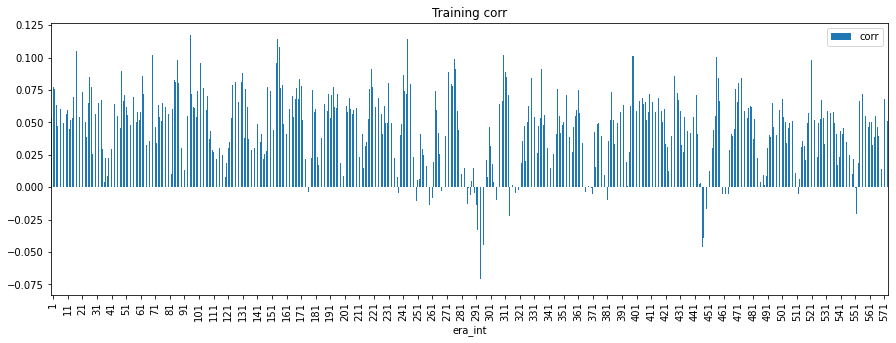

In [ ]:
metrics = calculate_metrics(scores_train)
print(json.dumps(metrics, indent=2))
scores_train.reset_index().plot(
    kind="bar",
    figsize=(15, 5),
    x="era_int",
    y="corr",
    xticks=scores_train.index.to_list()[::10],
)

plt.title("Training corr")
plt.show()


{
  "mean": 0.01982910111914886,
  "std": 0.029732860314094344,
  "min": -0.08670536897074468,
  "max": 0.1188678815240783,
  "sharpe": 0.6669086293641658,
  "max_dd": 0.182676493517062
}


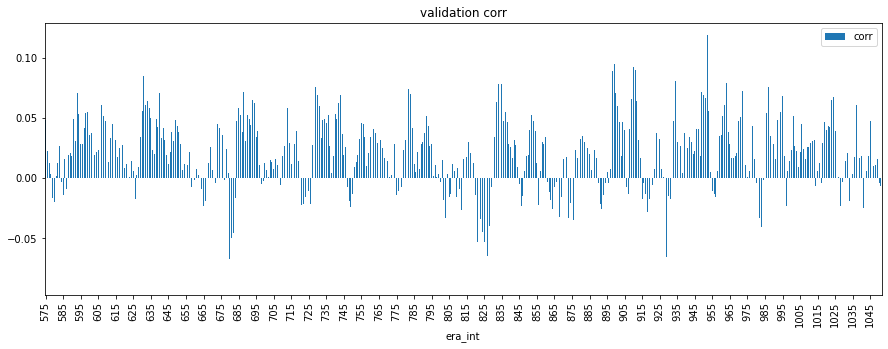

In [ ]:
metrics = calculate_metrics(scores_valid)
print(json.dumps(metrics, indent=2))
scores_valid.reset_index().plot(
    kind="bar",
    figsize=(15, 5),
    x="era_int",
    y="corr",
)
plt.xticks(
    ticks=range(0, len(scores_valid), 10), labels=scores_valid.index.to_list()[::10]
)
plt.title("validation corr")
plt.show()


In [ ]:
validation["example_preds"] = validation_example_preds

In [ ]:
diagnosis = validation[["era_int", PREDICTION_NAME, TARGET_NAME, "example_preds"]].reset_index()
combined = pd.merge(
    diagnosis,
    meta_model,
    on=["id"],
    how="right"
).dropna(axis=0)

pred2meta_model_corr = (
    combined[["era_int", "numerai_meta_model", PREDICTION_NAME]]
    .groupby("era_int")
    .progress_apply(
        lambda d: unif(d[PREDICTION_NAME]).corr(d["numerai_meta_model"])
    )
    .sort_index()
    .rename("pred2meta_model_corr")
)
example_preds_corr = (
    combined[["era_int", "example_preds", PREDICTION_NAME]]
    .groupby("era_int")
    .progress_apply(
        lambda d: unif(d[PREDICTION_NAME]).corr(d["example_preds"])
    )
    .sort_index()
    .rename("pred2example_preds_corr")
)

example2meta_model_corr = (
    combined[["era_int", "example_preds", "numerai_meta_model"]]
    .groupby("era_int")
    .progress_apply(
        lambda d: unif(d["numerai_meta_model"]).corr(d["example_preds"])
    )
    .sort_index()
    .rename("example2meta_model_cor")
)

100%|██████████| 164/164 [00:00<00:00, 181.76it/s]


pred2meta_model_corr       0.564351
pred2example_preds_corr    0.387241
example2meta_model_cor     0.621322
dtype: float64


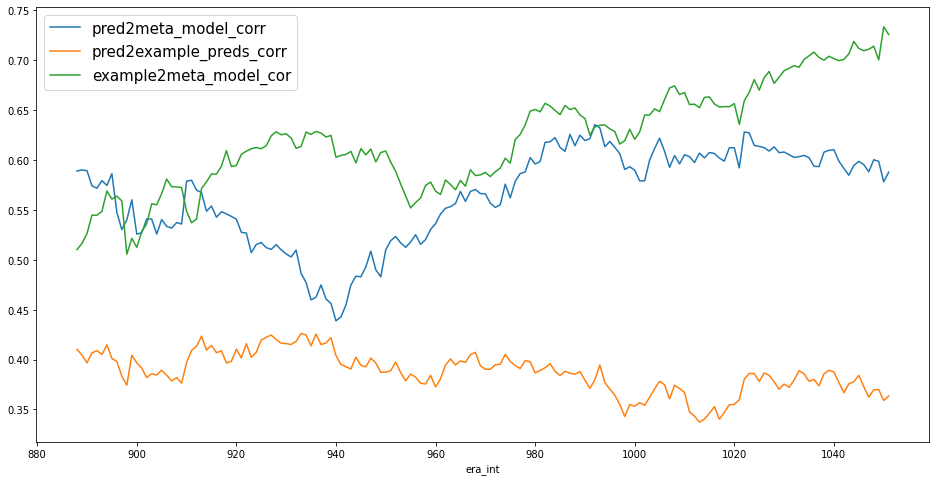

In [ ]:
correlations = pd.concat([
    pred2meta_model_corr,
    example_preds_corr,
    example2meta_model_corr,
], axis=1)

print(correlations.mean(0))

correlations.plot(figsize=(16, 8)).legend(fontsize=15, loc="upper left")

plt.show()

In [ ]:
# torch.save(transformer.state_dict(), "transformer.pth")

In [ ]:
if "transformer.pth" in os.listdir():
    transformer = transformer = Transformer(
        input_dim=FEATUER_DIM,
        d_model=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
    )
    transformer.load_state_dict(torch.load("transformer.pth"))
    transformer = transformer.to(device)
    transformer.eval()

In [ ]:
def prepare_live(data):

    inputs = torch.from_numpy(
                data[feature_names].values.astype(np.int8))
    
    padded_inputs, masks_inputs = pad_sequence(
            [inputs], padding_value=PADDING_VALUE, max_len=MAX_LEN)
    
    return padded_inputs, masks_inputs

In [ ]:
input_live, mask_live = prepare_live(live)
input_live, mask_live = input_live.to(device), mask_live.to(device)
preds_live = transformer(input_live/4.0, mask_live)[0][mask_live.view(-1).nonzero()].squeeze(1).detach().cpu().numpy()
live["prediction"] = preds_live[:, 0]

In [ ]:
napi = NumerAPI()
current_round = napi.get_current_round()

validation["prediction"].to_csv(f"validation_predictions_{current_round}.csv")
live["prediction"].to_csv(f"live_predictions_{current_round}.csv")

## Era Clustering using Embeddings

In [ ]:
def embeddings_on_era2data(era2data, transformer, device="cpu"):

    """
    Embeddings from encoder (6000, HIDDEN_DIM) for each era
    """
    transformer.eval()
    with torch.no_grad():
        preds = []
        for era_num in tqdm(era2data):
            batch = era2data[era_num]

            padded_inputs = batch[0].to(device=device)
            padded_labels = batch[1].to(device=device)
            masks_inputs = batch[2].to(device=device)

            outputs = transformer(padded_inputs / 4.0, masks_inputs)
            preds.append(
                outputs[0][masks_inputs.view(-1).nonzero()]
                .squeeze(1)
                .detach()
                .cpu()
                .numpy()[0, :]
            )

    preds = np.array(preds)
    return preds

In [ ]:
era_embeds_train = embeddings_on_era2data(era2data_train, transformer=transformer.encoder.to(device), device=device)
era_embeds_valid = embeddings_on_era2data(era2data_validation, transformer=transformer.encoder.to(device), device=device)
gc.collect()

100%|██████████| 477/477 [00:37<00:00, 12.63it/s]


78422

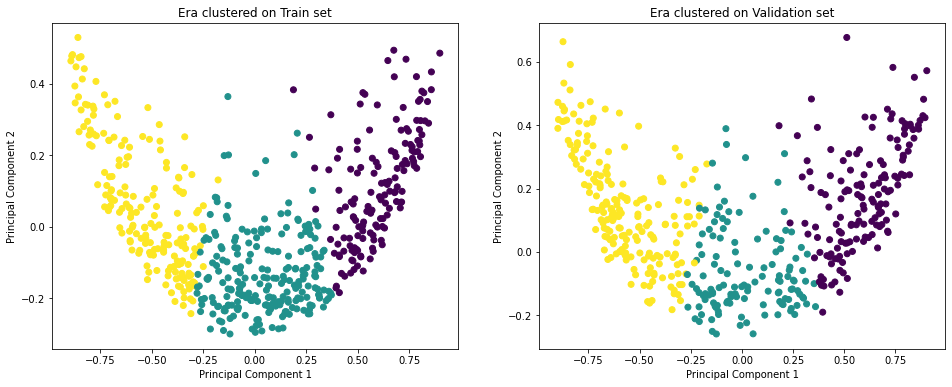

In [ ]:
# Load data
data_train = era_embeds_train.copy()
data_valid = era_embeds_valid.copy()

data_train = normalize(data_train)
data_valid = normalize(data_valid)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=5, svd_solver="full")
pca.fit_transform(data_train)
data_pca_train = pca.transform(data_train)
data_pca_valid = pca.transform(data_valid)

# Apply k-means++ clustering
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0, algorithm="lloyd", n_init=10, max_iter=100)
kmeans.fit(data_pca_train)
clusters_train = kmeans.predict(data_pca_train)
clusters_valid = kmeans.predict(data_pca_valid)

fig, axs = plt.subplots(1, 2, figsize=(16, 6)) 
axs[0].scatter(data_pca_train[:, 0], data_pca_train[:, 1], c=clusters_train, linewidths=1)
axs[0].set_title('Era clustered on Train set')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')

axs[1].scatter(data_pca_valid[:, 0], data_pca_valid[:, 1], c=clusters_valid, linewidths=1)
axs[1].set_title('Era clustered on Validation set')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')

plt.show()